# Model Export

In this notebook, we perform the necessary steps to export the features and the final fit model for steamlit deployement. This includes:
- separating the test set for final prediction
- Reproducing the feature engineering steps
- Adding uncertainty to non-deterministic exogenous features
- Fitting and saving SARIMAX model using the grid-search parameters
- saving the model and the exogenous test set for streamlit deployment

# Libraries

In [1]:
import pickle
import joblib

import sys
sys.path.append('../src')
from utils import add_uncertainty, sarimax_model, evaluate_model, visualize_prediction

# Constants
FIGSIZE = (16, 5)
FIGSIZE_LONG=(20, 6)

# Parameters

In [2]:
forecast_horizon = 48
target_col = 'EnergyConsumption'

# Loading cleaned data
Loading the cleaned data from EDA phase

In [3]:
with open('../data/data_cleaned.pkl', 'rb') as f:
    data_cleaned = pickle.load(f)

df_data = data_cleaned['df_data']
df_data = df_data.drop(columns=['DayOfWeek','RollingMean']).rename(columns = {'DayOfWeek_ext':'DayOfWeek'})
df_data.head()


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Date,Time,DayOfWeek
Timestamp,,,,,,,,,,,,
2022-01-04 00:00:00,25.080881,59.671534,1897.702224,8,Off,Off,14.391800,No,75.913906,2022-01-04,0,Tuesday
2022-01-04 01:00:00,25.792512,33.892216,1849.829581,7,On,Off,25.875969,Yes,84.191467,2022-01-04,1,Tuesday
2022-01-04 02:00:00,26.386079,43.295778,1851.597741,5,On,Off,17.471965,Yes,75.251764,2022-01-04,2,Tuesday
2022-01-04 03:00:00,22.140257,49.424878,1037.206885,7,Off,On,3.329908,Yes,75.014471,2022-01-04,3,Tuesday
2022-01-04 04:00:00,24.175776,41.800150,1198.625224,6,Off,Off,18.470624,No,69.365745,2022-01-04,4,Tuesday


# Forecast/ Train data split
- We preserve the last 48 hours of data as the forecast set
- The training set is also used for fitting the SARIMAX model

In [4]:
train_hr = df_data.iloc[:-forecast_horizon][target_col].asfreq('h')
test_hr = df_data.iloc[-forecast_horizon:][target_col].asfreq('h')
print(len(train_hr), len(test_hr))

880 48


# Feature Engineering

In [5]:
cat_cols = df_data.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['Date', 'Time']]
# num_cols = df_data.select_dtypes(include=['int64', 'float64']).columns

print('Categorical Features: ', cat_cols)
# print('\nNumerical Features: ', num_cols)
for col in cat_cols:
    print(f'Unique values in {col}: {df_data[col].unique()}')
# df_data[cat_cols].head()

df_features = df_data.copy()
df_features['HVACUsage'] = df_features['HVACUsage'].map({'On': 1, 'Off': 0})
df_features['LightingUsage'] = df_features['LightingUsage'].map({'On':1, 'Off': 0})
df_features['Holiday'] = df_features['Holiday'].map({'Yes':1, 'No': 0})
df_features.head(3)

df_features['DayOfWeek'] = df_features.index.weekday
df_features['Month'] = df_features.index.month
df_features.head(3)

num_cols = df_features.columns.difference(['Date', 'Time','EnergyConsumption'])
print(num_cols)
rol_features = []
for col in num_cols:
    feat = f'{col}_rol'
    df_features[feat] = df_features[col].shift(1).rolling(24).mean()
    # df_features[feat].fillna(method='ffill', inplace=True)  # Fill NaN values with the last valid value
    rol_features.append(feat)

df_features = df_features.ffill().bfill()
df_features[rol_features]

num_cols_laged = ['EnergyConsumption','HVACUsage','Humidity', 'LightingUsage', 'Occupancy', 'RenewableEnergy',
                  'SquareFootage', 'Temperature']
lag_features = [f'{feat}_lag' for feat in num_cols_laged]
for feat in num_cols_laged:
    df_features[f'{feat}_lag'] = df_features[feat].shift(1)
print(lag_features)

lag2_features = []
for col in num_cols_laged:
    feat = f'{col}_lag2'
    df_features[feat] = df_features[col].shift(2)
    lag2_features.append(feat)

df_features.describe()

Categorical Features:  ['HVACUsage', 'LightingUsage', 'Holiday', 'DayOfWeek']
Unique values in HVACUsage: ['Off' 'On']
Unique values in LightingUsage: ['Off' 'On']
Unique values in Holiday: ['No' 'Yes']
Unique values in DayOfWeek: ['Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday' 'Monday']
Index(['DayOfWeek', 'HVACUsage', 'Holiday', 'Humidity', 'LightingUsage',
       'Month', 'Occupancy', 'RenewableEnergy', 'SquareFootage',
       'Temperature'],
      dtype='object')
['EnergyConsumption_lag', 'HVACUsage_lag', 'Humidity_lag', 'LightingUsage_lag', 'Occupancy_lag', 'RenewableEnergy_lag', 'SquareFootage_lag', 'Temperature_lag']


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,Holiday,EnergyConsumption,Time,...,SquareFootage_lag,Temperature_lag,EnergyConsumption_lag2,HVACUsage_lag2,Humidity_lag2,LightingUsage_lag2,Occupancy_lag2,RenewableEnergy_lag2,SquareFootage_lag2,Temperature_lag2
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,...,927.000000,927.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000,926.000000
mean,25.006549,45.424276,1501.761038,4.538793,0.494612,0.498922,15.226672,0.464440,77.163530,11.431034,...,1502.282743,25.008659,77.169827,0.494600,45.442555,0.498920,4.538877,15.234850,1502.491385,25.008519
std,2.834891,8.550843,288.772127,2.863037,0.500241,0.500268,8.758075,0.499003,8.039079,6.912271,...,288.490109,2.835693,8.045639,0.500241,8.546969,0.500269,2.865282,8.755805,288.576021,2.837222
min,20.007565,30.015975,1000.512661,0.000000,0.000000,0.000000,0.006642,0.000000,56.038163,0.000000,...,1000.512661,20.007565,56.038163,0.000000,30.015975,0.000000,0.000000,0.006642,1000.512661,20.007565
25%,22.674923,38.359591,1250.254067,2.000000,0.000000,0.000000,7.677564,0.000000,71.587600,5.000000,...,1250.444519,22.673669,71.590544,0.000000,38.385824,0.000000,2.000000,7.691198,1250.415573,22.672415
50%,24.784643,45.989516,1507.967426,5.000000,0.000000,0.000000,15.114307,0.000000,76.943696,11.000000,...,1508.016302,24.790528,76.949101,0.000000,46.001372,0.000000,5.000000,15.114307,1508.209433,24.784643
75%,27.439308,52.596376,1743.500826,7.000000,1.000000,1.000000,23.048041,1.000000,82.966785,17.000000,...,1744.001449,27.441776,82.969675,1.000000,52.660798,1.000000,7.000000,23.074356,1744.502071,27.444243
max,29.998671,59.969085,1999.982252,9.000000,1.000000,1.000000,29.965327,1.000000,99.201120,23.000000,...,1999.982252,29.998671,99.201120,1.000000,59.969085,1.000000,9.000000,29.965327,1999.982252,29.998671


# Exogenous variables for SARIMAX
We create the exogenous features for the SARIMAX model based on:
- lagged features
- rolling features
- regression features with added uncertainty


Exogenous features for SARIMAX:
 ['HVACUsage', 'Humidity', 'LightingUsage', 'Occupancy', 'RenewableEnergy', 'SquareFootage', 'Temperature']
Noise ratio: 0.01


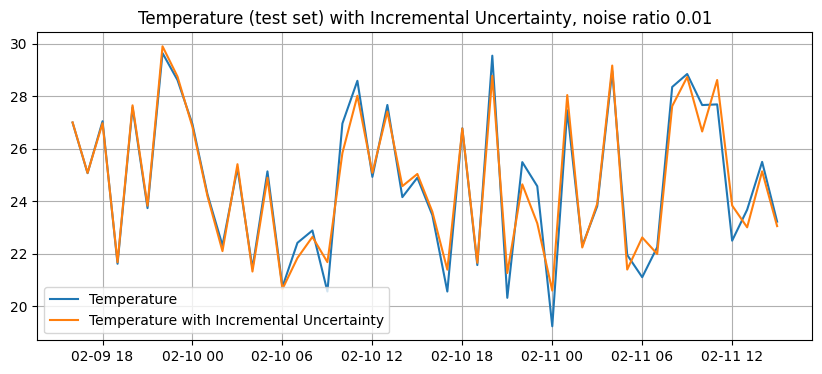

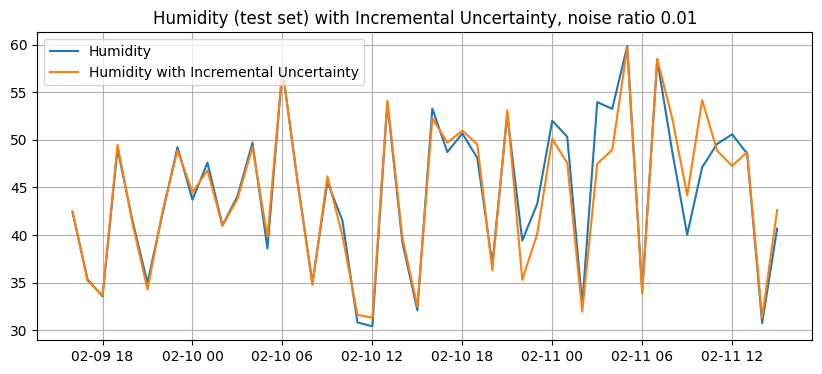

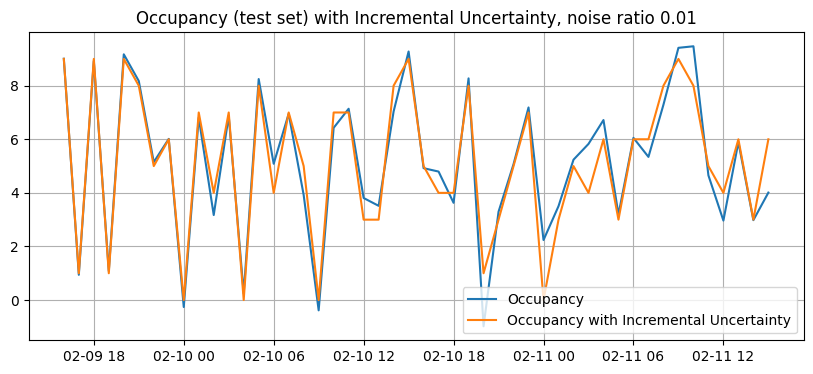

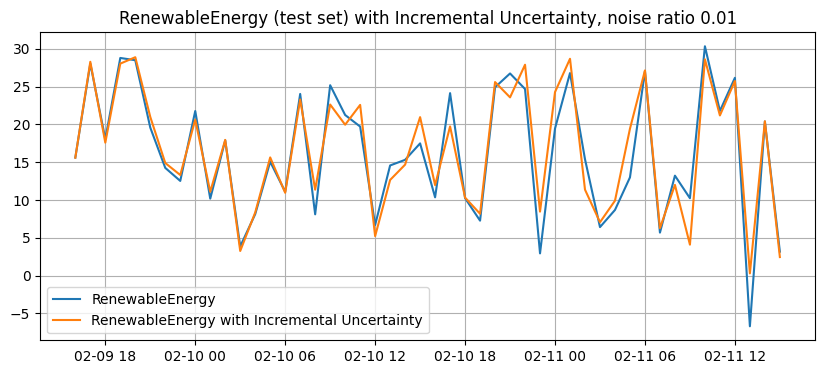

In [6]:
# input features including lagged features, rolling features, and regression features
ex_cols = num_cols_laged 
# ex_cols = lag_features + rol_features + lag2_features + num_cols_laged + ['Holiday', 'DayOfWeek']
ex_cols = [col for col in ex_cols if col != 'EnergyConsumption']

# Regression features with added uncertainty
RW_cols = ['Temperature','Humidity','Occupancy','RenewableEnergy']

print('Exogenous features for SARIMAX:\n', ex_cols)

# filling the Nan value of lags and rolling features
df_features = df_features.ffill().bfill()

exog_train = df_features.iloc[:-forecast_horizon][ex_cols].asfreq('h')
exog_test = df_features.iloc[-forecast_horizon:][ex_cols].asfreq('h')
# len(exog_train), len(train_hr)

noise_ratio = 0.01
print(f'Noise ratio: {noise_ratio}')
# exog_train_rw = exog_train.copy()
# exog_test_rw = exog_test.copy()

for col in RW_cols:
    exog_train, exog_test = add_uncertainty(exog_train, exog_test, col, noise_ratio, verbose=True)


In [7]:
# saving the data needed to load the model in streamlit
# a dictionary with all data
data_split = {
    'train_hr': train_hr,
    'exog_train': exog_train,
    'exog_test': exog_test
}
# saving the data
with open('../data/data_split.pkl', 'wb') as f:
    pickle.dump(data_split, f)

# Fitting and exporting SARIMAX
We fit the SARIMAX model using the grid-search parameters from the previous notebook.
- order = (4, 0, 10)
- seasonal_order = (1, 0, 1, 24).  

We save the model using joblib.

Rolling-Window Forecast Evaluation:
MAE:  4.716
RMSE: 35.198
MAPE: 6.18%
R2:   0.3786


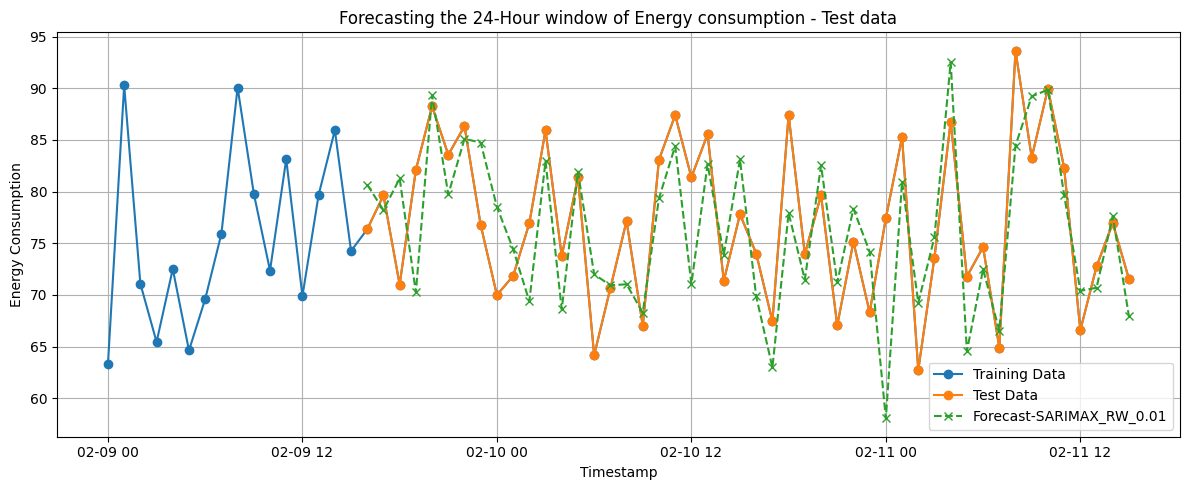

{'mae': 4.715756946870355,
 'rmse': 35.19792557829591,
 'mape': np.float64(6.181010587996438),
 'r2': 0.37855524173271893}

In [8]:
order = (4, 0, 10)
seasonal_order = (1, 0, 1, 24)

df_predictions_sarimax, model_result = sarimax_model(train_hr, test_hr,
                    order, seasonal_order,
                    exog_train, exog_test)

metrics =  evaluate_model(df_predictions_sarimax, verbose=True)

# Visualizaiton of resuilts
model  = f'SARIMAX_RW_{noise_ratio:.2f}'
visualize_prediction([df_predictions_sarimax], [model], df_data, last_n_samples=64)
metrics

In [9]:
import json

# saving the model
joblib.dump(model_result, "../models/sarimax_model.pkl")

# Save model efficiently
model_result.save("../models/sarimax_model.zip")

# Save checkpoint: config + fitted parameters only
checkpoint = {
    "order": order,
    "seasonal_order": seasonal_order,
    "params": model_result.params.tolist()
}

with open("../models/sarimax_checkpoint.json", "w") as f:
    json.dump(checkpoint, f)

# Forecasting for selected horizon
We use the fit model to predict the decided horizon of data.


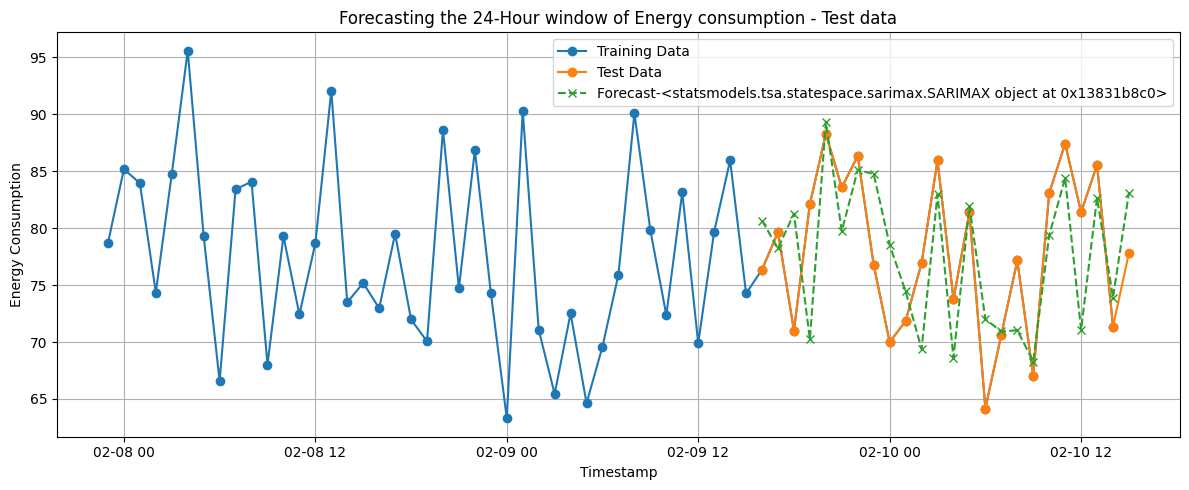

In [35]:
# LOADING the model
from statsmodels.tsa.statespace.sarimax import SARIMAX

selected_horizon = 24

# Load checkpoint
with open("../models/sarimax_checkpoint.json") as f:
    checkpoint = json.load(f)

order = tuple(checkpoint["order"])
seasonal_order = tuple(checkpoint["seasonal_order"])
params = checkpoint["params"]
# Rebuild model and inject parameters
model = SARIMAX(train_hr, exog=exog_train, order=order, seasonal_order=seasonal_order)
fit_model = model.filter(params)



df_data_test = df_data.iloc[:-(forecast_horizon-selected_horizon+1)]
exog_forecast = exog_test.iloc[:selected_horizon]
forecast = fit_model.forecast(steps=len(exog_forecast),
                        exog=exog_forecast)
forecast_obj = fit_model.get_forecast(steps=len(exog_forecast), exog=exog_forecast)
forecast_df = forecast_obj.summary_frame()


import pandas as pd
df_predictions_sarimax_horizon = pd.DataFrame(index=exog_forecast.index)
df_predictions_sarimax_horizon['prediction'] = forecast
df_predictions_sarimax_horizon['truth'] = test_hr.iloc[:selected_horizon].values

# Visualization of results
visualize_prediction([df_predictions_sarimax_horizon], [model], df_data_test, last_n_samples=64)
# forecast_df


## Visualization of Confidence Interval

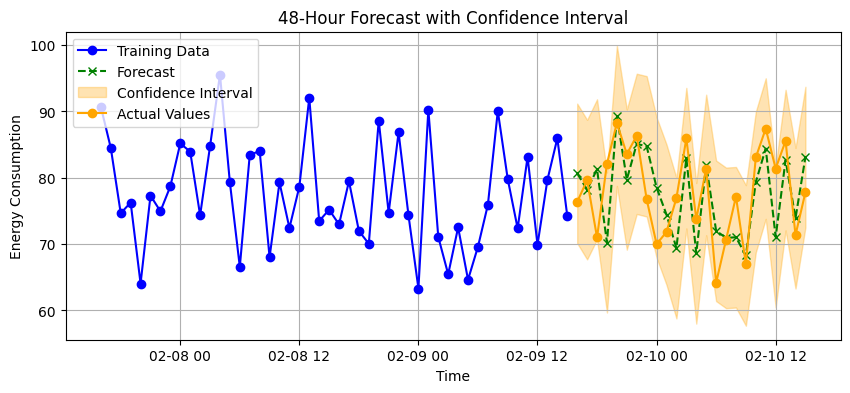

In [36]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(figsize=(10, 4))
n_history = 48+forecast_horizon
df_data_train = df_data.iloc[-n_history:-forecast_horizon]
df_data_test = df_data.iloc[-forecast_horizon:-(forecast_horizon-selected_horizon)]

# also with the actual EnergyConsumption
ax.plot(df_data_train.index, df_data_train['EnergyConsumption'], label='Training Data', color='blue', marker='o')

# Plot mean forecast
ax.plot(forecast_df.index, forecast_df['mean'], label='Forecast', color='green', marker='x', linestyle='--')

# Plot confidence interval
ax.fill_between(forecast_df.index,
                forecast_df['mean_ci_lower'],
                forecast_df['mean_ci_upper'],
                color='orange', alpha=0.3, label='Confidence Interval')

# plot the actual values
ax.plot(df_data_test.index, df_data_test['EnergyConsumption'], label='Actual Values', color='orange', marker='o')

ax.set_title(f"{forecast_horizon}-Hour Forecast with Confidence Interval")
ax.set_xlabel("Time")
ax.set_ylabel("Energy Consumption")
ax.legend()
ax.grid(True)

